# Fitting a model to data

In this tutorial we will see how one can use ``pocoMC`` to fit a model to some data.

The model that we will use is a *cosine* oscilation of frequency $\omega$ and phase $\phi$ with a linearly-evolving amplitude:

$$
x(t) = (A + B\,t) \, cos(\omega\,t + \phi)
$$

As usually, we begin by importing ``numpy``, ``matplotlib`` and of course ``pocoMC``:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pocomc as pc

## Definiing the model and generating the data

We define the model as function that accepts an array of parameters and an array of the time instances. We then use the same model to
generate some data by specifying the *true* parameters (these will be what we will attempt to estimate), a noise level ``sigma`` and the
time instances ``t``. Finally, we plot the data along with the model that we used to generate them.

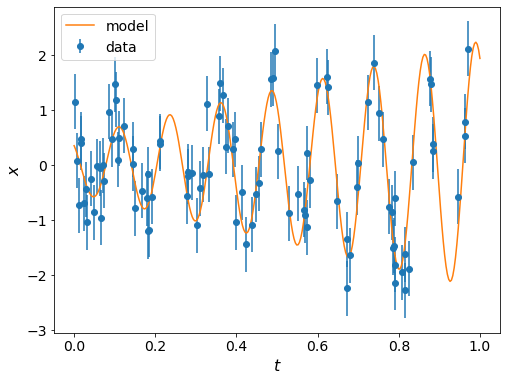

In [17]:
# Model with linearly-evolving amplitude
def model(params, t):
    A, B, omega, phi, = params
    return (A + B * t) * np.cos(omega * t + phi)

# True parameters
params_true = np.array([0.5, 1.75, 50.0, 0.8])

# Time instances corresponding to available data
t = np.random.uniform(0.0, 1.0, 100)
idx = np.argsort(t)
t = t[idx]

# Standard deviation of Gaussian noise of the data
sigma = 0.5

# Simulated data
data = np.random.normal(model(params_true, t), sigma) 

# Time range used for plotting only
t_range = np.linspace(0.0, 1.0, 300)

# Figure
plt.figure(figsize=(8,6))
plt.errorbar(t, data, yerr=sigma, fmt="o", label='data')
plt.plot(t_range, model(params_true, t_range), label='model')
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$x$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

## Log-likelihood, log-prior and bounds

We then define the log-likelihood and log-prior functions, as well as the low & high parameter bounds.

In [18]:
# Log-likelihood functions
def log_like(params, t, data, sigma):
    m = model(params, t)
    diff = m - data
    return -0.5 * np.dot(diff, diff) / sigma**2.0

# Log-prior probability density function
def log_prior(params, bounds):
    if np.any(params < bounds.T[0]) or np.any(params > bounds.T[1]):
        return -np.inf
    else:
        return 0.0

# Parameter bounds
bounds = np.array([[-5.0, 5.0], # A
                   [-5.0, 5.0], # B
                   [10.0, 100.0], # omega
                   [0.0, np.pi]]) # phi

## Initial particle positions

We generate the initial positions of the particles by sampling from the prior.

In [19]:
n_particles = 1000
n_dim = 4

prior_samples = np.random.uniform(low = bounds.T[0], high= bounds.T[1], size=(n_particles, n_dim))

## Initialising and running Preconditioned Monte Carlo

We initialise the sampler by providing:
- the number of particles ``n_particles``,
- the number of dimensions ``n_dim``,
- the log-likelihood function ``log_like``,
- the log-prior probability density function ``log_prior``,
- the parameter bounds ``bounds``,
- a list ``log_likelihood_args`` with the additional arguments that enter in the log-likelihood function ``loglike``,
- a list ``log_prior_args`` with the additional arguments that enter in the log-prior function ``logprior``,

We then run the sampler by providing the initial positions of the walkers ``prior_samples`` and also ask to add 2000 extra samples at the end.

In [20]:
# Sampler initialisation
sampler = pc.Sampler(n_particles,
                     n_dim,
                     log_likelihood=log_like,
                     log_prior=log_prior,
                     bounds=bounds,
                     log_likelihood_args=[t, data, sigma],
                     log_prior_args=[bounds]
                    )

# Run sampler
sampler.run(prior_samples)

# Add extra samples
sampler.add_samples(2000)

## Results

We can get the results from the ``results`` dictionary and then plot the ``run``, ``trace`` and ``corner`` plot using the plotting utilities of ``pocoMC``.

In [23]:
results = sampler.results

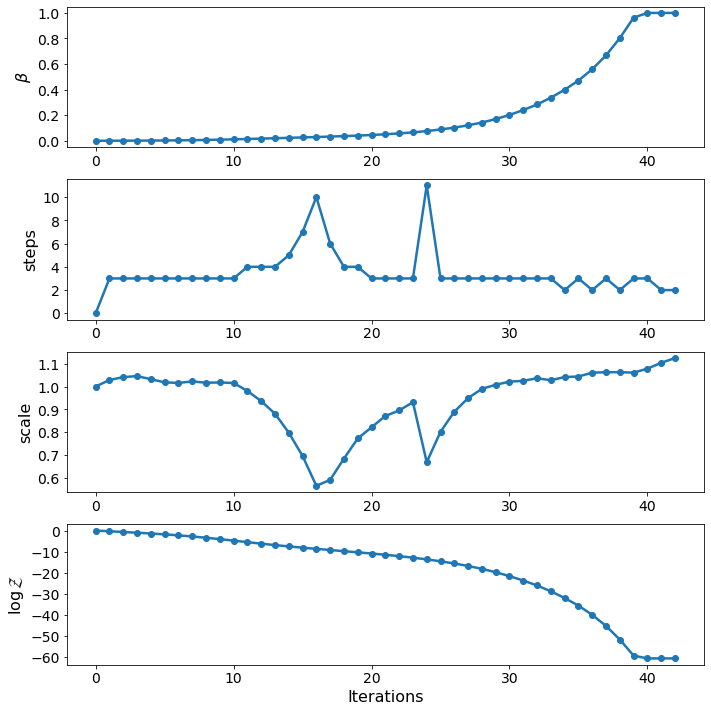

In [24]:
pc.plotting.run(results);

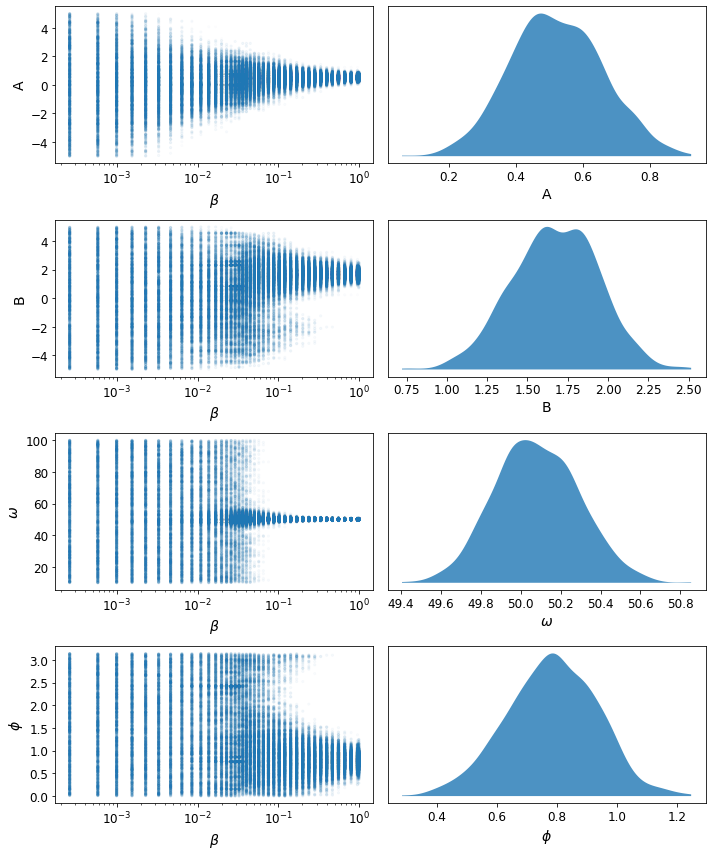

In [45]:
pc.plotting.trace(results, labels=['A', 'B', r'$\omega$', r'$\phi$']);

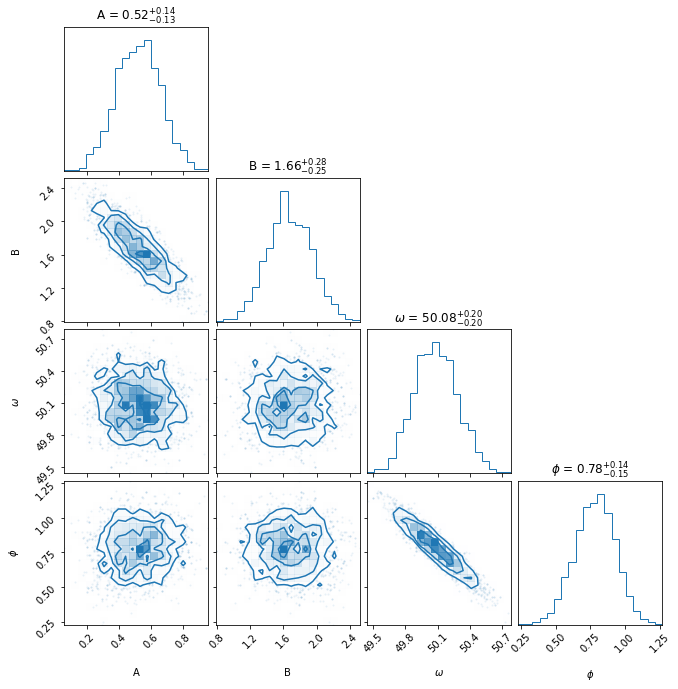

In [44]:
pc.plotting.corner(results, labels=['A', 'B', r'$\omega$', r'$\phi$']);

We can also compute any expectation values we want using the posterior samples.

In [47]:
print('Mean values = ', np.mean(results['samples'], axis=0))
print('Standard deviation values = ', np.std(results['samples'], axis=0))

Mean values =  [ 0.5217232   1.6749852  50.084835    0.78184247]
Standard deviation values =  [0.1372351  0.2690071  0.2037325  0.14550509]


## Posterior predictive check

Finally, we can perform some Posterior Predictive Checks to assess the predictive performance of our fit.

The distribution that reflects the probability of new data given the current data is the *posterior predictive distribution*:

$$
P(D_{new}|D) = \int_{\Theta} P(D_{new}|\theta,D)P(\theta|D)d\theta
$$
where $P(D_{new}|\theta,D) = P(D_{new}|\theta)$ assuming $D_{new}$ is independent of $D$.

The easiest way to sample from the posterior predictive distribution is to use the posterior samples that we have already to generate the new data.

In [28]:
sim_data = []

for params in results['samples']:
    sim_data.append(np.random.normal(model(params, t_range), sigma))

sim_data = np.array(sim_data)

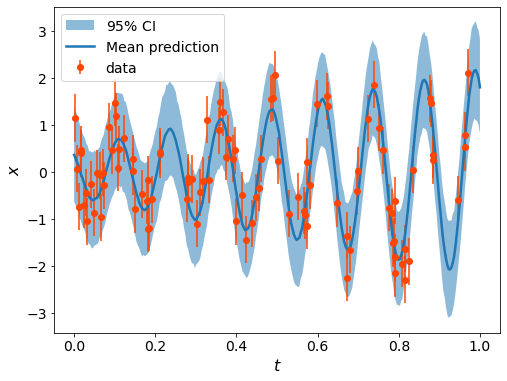

In [42]:
plt.figure(figsize=(8,6))
plt.fill_between(t_range, np.percentile(sim_data,2.5,axis=0),np.percentile(sim_data,97.5,axis=0),alpha=0.5, label=r'$95\%$ CI')
plt.errorbar(x=t, y=data, yerr=sigma, marker='o', ls=' ', color='orangered', label='data')
plt.plot(t_range, np.mean(sim_data, axis=0), lw=2.5, label='Mean prediction')
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$x$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()